In [1]:
from keras.applications.vgg16 import VGG16
from keras.applications.vgg19 import VGG19
from keras.applications.resnet50 import ResNet50
from keras.models import Model
from keras.layers import Dense, LSTM, TimeDistributed, Flatten, Input,GRU
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import numpy as np
import tensorflow as tf
from keras.callbacks import EarlyStopping

def build_model(application,model_layer):
    # Load the model
    base_model = application(weights='imagenet', include_top=False, input_shape=(64, 64, 3))

    # Make the base model non-trainable
    for layer in base_model.layers:
        layer.trainable = False

    # Define the input shape for our final model
    # The shape should be (num_frames, height, width, channels)
    # Replace num_frames with the number of frames in our video data
    input_shape = (16, 64, 64, 3)
    model_input = Input(shape=input_shape)

    # Add a TimeDistributed wrapper to handle the time dimension in the video data
    x = TimeDistributed(base_model)(model_input)

    # Flatten the output
    x = TimeDistributed(Flatten())(x)

    # Add an LSTM layer to handle the sequence of features extracted from the frames
    x = model_layer(256)(x)

    # Add a Dense layer for binary classification
    output = Dense(2, activation='softmax')(x)
    return Model(inputs=model_input, outputs=output)


In [2]:
features,labels=np.load("Features/features_Own.npy"),np.load("Features/labels_Own.npy")

In [3]:
one_hot_encoded_labels = to_categorical(labels)
features_train, features_test, labels_train, labels_test = train_test_split(features, one_hot_encoded_labels, test_size=0.2,
                                                                            shuffle=True, random_state=42)

In [4]:
# Create a new model
ResNet50_model = build_model(ResNet50,LSTM)

In [7]:
early_stopping_callback = EarlyStopping(monitor = 'val_accuracy', patience = 10, restore_best_weights = True)

# Create ReduceLROnPlateau Callback to reduce overfitting by decreasing learning
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',factor=0.6,patience=5,min_lr=0.00005,verbose=1)
 
# Compiling the model 
ResNet50_model.compile(loss = 'categorical_crossentropy', optimizer = 'sgd', metrics = ["accuracy"]) 
 
# Fitting the model 
history = ResNet50_model.fit(x = features_train, y = labels_train, epochs = 50, batch_size = 10 ,
                                             shuffle = True, validation_split = 0.2, callbacks = [early_stopping_callback,reduce_lr])

Epoch 1/50
64/64 [==============================] - 217s 3s/step - loss: 0.7525 - accuracy: 0.5274 - val_loss: 0.7484 - val_accuracy: 0.4500 - lr: 0.0100
Epoch 2/50
64/64 [==============================] - 183s 3s/step - loss: 0.7271 - accuracy: 0.5164 - val_loss: 0.7580 - val_accuracy: 0.4500 - lr: 0.0100
Epoch 3/50
64/64 [==============================] - 175s 3s/step - loss: 0.6994 - accuracy: 0.5430 - val_loss: 0.6998 - val_accuracy: 0.5500 - lr: 0.0100
Epoch 4/50
64/64 [==============================] - 169s 3s/step - loss: 0.7030 - accuracy: 0.5368 - val_loss: 0.7089 - val_accuracy: 0.5500 - lr: 0.0100
Epoch 5/50
64/64 [==============================] - 171s 3s/step - loss: 0.6943 - accuracy: 0.5321 - val_loss: 0.7089 - val_accuracy: 0.5500 - lr: 0.0100
Epoch 6/50
64/64 [==============================] - 182s 3s/step - loss: 0.6960 - accuracy: 0.5336 - val_loss: 0.6704 - val_accuracy: 0.5562 - lr: 0.0100
Epoch 7/50
64/64 [==============================] - 180s 3s/step - loss: 0.6

7/7 [==============================] - 46s 5s/step


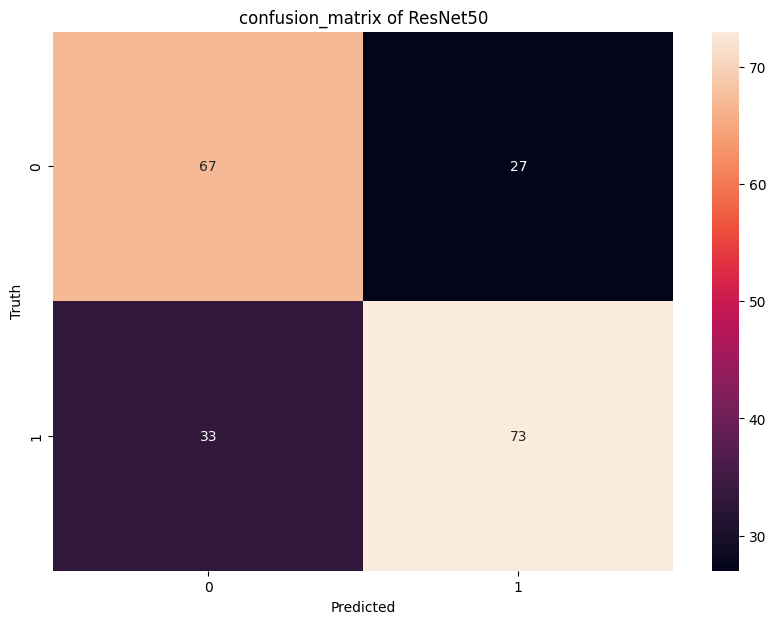


Classification Report of ResNet50:
              precision    recall  f1-score   support

           0       0.67      0.71      0.69        94
           1       0.73      0.69      0.71       106

    accuracy                           0.70       200
   macro avg       0.70      0.70      0.70       200
weighted avg       0.70      0.70      0.70       200



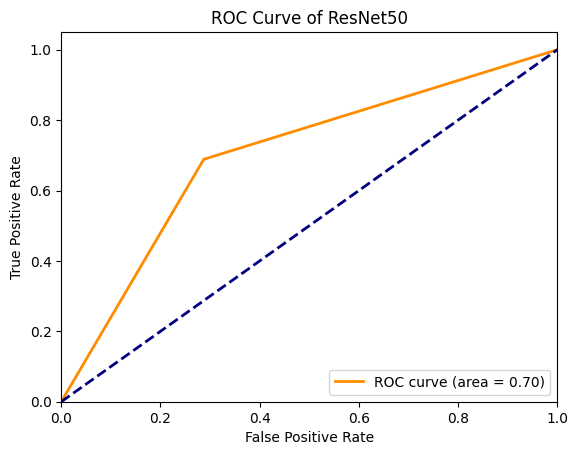

In [8]:
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from sklearn.model_selection import validation_curve
import matplotlib.pyplot as plt
from keras.utils import to_categorical
import seaborn as sns

# Assuming `predicted_labels` are the predictions of our model on the test set
predicted_labels = ResNet50_model.predict(features_test)
predicted_labels = np.argmax(predicted_labels, axis=1)
true_labels = np.argmax(labels_test, axis=1)
# Confusion Matrix
cm = confusion_matrix(true_labels, predicted_labels)

plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d')
plt.title("confusion_matrix of ResNet50")
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.show()

# Classification Report
print("\nClassification Report of ResNet50:")
print(classification_report(true_labels, predicted_labels))

# ROC Curve
fpr, tpr, _ = roc_curve(true_labels, predicted_labels)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve of ResNet50')
plt.legend(loc="lower right")
plt.show()


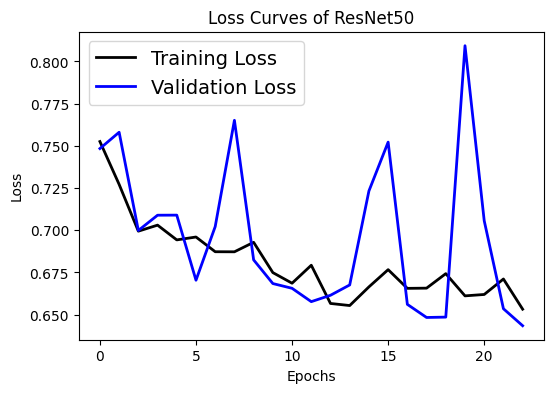

In [9]:
plt.figure(figsize=[6,4])
plt.plot(history.history['loss'], 'black', linewidth=2.0)
plt.plot(history.history['val_loss'], 'blue', linewidth=2.0)
plt.legend(['Training Loss', 'Validation Loss'], fontsize=14)
plt.xlabel('Epochs', fontsize=10)
plt.ylabel('Loss', fontsize=10)
plt.title('Loss Curves of ResNet50', fontsize=12)
plt.show()